In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import solve as solve
from scipy.stats import special_ortho_group
from scipy import linalg
from scipy.sparse.linalg import eigsh
import itertools
import seaborn as sns

### Optimal solution

In [2]:
def optimal(A,B,C,D,a,b): 
    
    M = np.block([[A,B],[C,D]])
    
    m = np.block([a,b])
    
    return - solve(M,m) #np.dot(np.linalg.inv(M),m) solve(M,m)
    

### Optimization algorithms

In [6]:

def grad_l1(A,B,a,x,y): 
    return np.dot(A,x) + np.dot(B,y)+a

def grad_l2(C,D,b,x,y): 
    return np.dot(D,y) + np.dot(C,x)+b

def sim_grad(A,B,C,D,a,b,opt,init_err,x0,y0,eta1,eta2,T):
    
    x=x0.copy()
    y=y0.copy()
    

    it = np.zeros(T)


    it[0] = init_err 
    
    for t in range(1,T): 
        
        g1= grad_l1(A,B,a,x,y)
        g2= grad_l2(C,D,b,x,y)
        
        x-=eta1*g1
        y-=eta2*g2
        

       
        ## Store optimality gap
        xy = np.block([x,y]) 
        it[t] =  np.linalg.norm(xy-opt)**2 
        
    return it


def extra_grad(A,B,C,D,a,b,opt,init_err,x0,y0,eta1,eta2,T):
    
    x=x0.copy()
    y=y0.copy()
    
 

    it = np.zeros(T)
    
    it[0] = init_err 
    for t in range(1,T): 
        
        g1= grad_l1(A,B,a,x,y)
        g2= grad_l2(C,D,b,x,y)
        
        x_half=x-eta1*g1
        y_half=y-eta2*g2
        
        
        g1_half = grad_l1(A,B,a,x_half,y_half)
        g2_half = grad_l2(C,D,b,x_half,y_half)
        
        x-=eta1*g1_half
        y-=eta2*g2_half

        
    
        ## Store optimality gap
        xy = np.block([x,y]) 
        it[t] =  np.linalg.norm(xy-opt)**2
        
    return it


def sim_sgngrad(A,B,C,D,a,b,opt,init_err,x0,y0,eta1,eta2,T):
    
    x=x0.copy()
    y=y0.copy()
    
 
    it =  np.zeros(T)
    
    it[0] = init_err 
    
    
    ### Initial l1 norm
    norm_g1_init= np.linalg.norm(grad_l1(A,B,a,x,y),1)
    norm_g2_init= np.linalg.norm(grad_l2(C,D,b,x,y),1)
    
    for t in range(1,T): 
        
        g1= grad_l1(A,B,a,x,y)
        g2= grad_l2(C,D,b,x,y)
        
        g1_linfty= np.sign(g1)*np.linalg.norm(g1,1)/norm_g1_init
        g2_linfty= np.sign(g2)*np.linalg.norm(g2,1)/norm_g2_init
        
        #print(g1_linfty)
        
        
        x-=eta1*g1_linfty
        y-=eta2*g2_linfty
        
    
        
        ## Store optimality gap
        xy = np.block([x,y]) 
        it[t] = np.linalg.norm(xy-opt)**2
        
    return it 


def sgn_EG(A,B,C,D,a,b,opt,init_err,x0,y0,eta1,eta2,T):
    
    x=x0.copy()
    y=y0.copy()
    
 
    it =  np.zeros(T)
 
    it[0] = init_err 

    for t in range(1,T): 
        
        g1= grad_l1(A,B,a,x,y)
        g2=grad_l2(C,D,b,x,y)
        
        g1_linfty= np.sign(g1)*np.linalg.norm(g1,1)
        g2_linfty= np.sign(g2)*np.linalg.norm(g2,1)
        
        
        x_half=x-eta1*g1_linfty
        y_half=y-eta2*g2_linfty
        
        g1_half= grad_l1(A,B,a,x_half,y_half)
        g2_half= grad_l2(C,D,b,x_half,y_half)  
        
        g1_halflinfty= np.sign(g1_half)*np.linalg.norm(g1_half,1)
        g2_halflinfty= np.sign(g2_half)*np.linalg.norm(g2_half,1)
        
        x-=eta1*g1_halflinfty
        y-=eta2*g2_halflinfty
        
        
      
   
        
        ## Store optimality gap
        xy = np.block([x,y]) 
        it[t] = np.linalg.norm(xy-opt)**2 
        
    return it


### Generate data

In [7]:
def generate_arthur(t,lamb_max,d): 
    A= (1-t)*np.eye(2*d)+t*np.ones((2*d,2*d))

    
    # Normalize
    for i in range(d): 
        A[:,i]/=np.linalg.norm(A[:,i])

    angle=np.dot(A[:,0],A[:,1])

    # Eigenvalues
    diag_gamma = np.diag(np.block([np.ones(2*d-1),lamb_max]))
   

    return np.dot( A,np.dot(diag_gamma,np.linalg.inv(A))), math.acos(angle)*180/math.pi
    

### Smoothness constants

In [8]:
def L2_function(J):
    eigs_val = eigsh(J.transpose().dot(J),which='LM',k=1,return_eigenvectors=False)
    return np.sqrt(eigs_val[0])

In [9]:
def L_infty(J):
    best_norm=-1
    dim=J.shape[0]
    X = np.array(list(itertools.product([-1, 1], repeat=dim)))
    X_arr=X[:,:dim]
    
    for j in range(2**(2*d)):

        x = X_arr[j,:]
        normJx=np.linalg.norm(np.dot(J,x),1)
        if normJx>best_norm:
            best_norm=normJx
        
    return best_norm

### Plots of the smoothness ratios

In [10]:
def smoothness(d,x0,eta1,T,ratio_tab,t_tab,dataset):
#https://scicomp.stackexchange.com/questions/33398/diagonalize-a-unitary-matrix-with-orthogonal-matrices-using-numpy
    
   
    
    smoothness_tab= np.zeros((len(ratio_tab),len(t_tab)))
    angle_tab=np.zeros(len(t_tab))
    
 

    i=0
    j=0

    for ratio in ratio_tab:
        j=0
        for t in t_tab:
   

            lamb_max= np.divide(2*d-1,2*d-ratio)*ratio#np.divide(1-1/d,1-ratio/d)#(d-1)/((d/ratio)-1)
            
            #print("Lambda_max: "+str(lamb_max))
            
              
            J,angle=generate_arthur(t,lamb_max,d)

  
            
            #eg = np.real(linalg.eig(J, left=False, right=False))
            #print(eg)
           
          
            L2=L2_function(J)
            L_inf=L_infty(J)
            #print("L_inf:"+str(L_inf ))
            #print("L_2:"+str(L2 ))
            #print('\n')
        
            smoothness_tab[i,j]=L_inf/L2 
            
            angle_tab[j]=angle
            

            j+=1
        i+=1
        
    return smoothness_tab,angle_tab

In [11]:
def exps(d,x0,y0,eta1,eta2,T,ratio_tab,t_tab,dataset):

    
    if dataset=="tristan":
    
        U =special_ortho_group.rvs(2*d)
        sum_col = np.zeros(2*d)
        for i in range(d): 
            sum_col+=U[:,i]
            
        
    
    a = np.random.normal(0, 1, d)
    b = np.random.normal(0, 1, d)

    gd=np.zeros((T,len(ratio_tab),len(t_tab)))
    eg=np.zeros((T,len(ratio_tab),len(t_tab)))
    gd_sgn=np.zeros((T,len(ratio_tab),len(t_tab)))
    eg_sgn=np.zeros((T,len(ratio_tab),len(t_tab)))
    
    eigs_tab= np.zeros((2*d,len(ratio_tab),len(t_tab)))
    L2_tab= np.zeros((len(ratio_tab),len(t_tab)))
    Linf_tab= np.zeros((len(ratio_tab),len(t_tab)))
    

    angle_tab=np.zeros(len(t_tab))

     
    i=0
    j=0

    for ratio in ratio_tab:
        j=0
        for t in t_tab:


            lamb_max= np.divide(2*d-1,2*d-ratio)*ratio

            
            J,angle=generate_arthur(t,lamb_max,d)


            A=np.real(J[:d,:d])
            B=np.real(J[:d,d:])
            C=np.real(J[d:,:d])
            D=np.real(J[d:,d:])
            opt = optimal(A,B,C,D,a,b)

            L2=L2_function(J)
            L_inf=L_infty(J)
            
          
            eigs_tab[:,i,j]=np.sort(np.real(linalg.eig(J, left=False, right=False)))[::-1] 
            L2_tab[i,j]=L2
            Linf_tab[i,j]=L_inf         
            
            init_err=np.linalg.norm( np.block([x0,y0]) -opt)**2
             
                
            ### Stepsizes for GD and sgnGD    
            eta1_l2= eta1/L2
            eta2_l2=eta2/L2
    
            
            
            eta1_linf= eta1/L_inf
            eta2_linf=eta2/L_inf
         

            it_gd=sim_grad(A,B,C,D,a,b,opt,init_err,x0,y0,eta1_l2,eta2_l2,T)
            #it_eg=extra_grad(A,B,C,D,a,b,opt,init_err,x0,y0,eta1_l2,eta2_l2,T)
            
            
            
            it_sgn= sim_sgngrad(A,B,C,D,a,b,opt,init_err,x0,y0,eta1_linf,eta2_linf,T)
            #it_eg_sgn=sgn_EG(A,B,C,D,a,b,opt,init_err,x0,y0,eta1_linf,eta2_linf,T)

            gd[:,i,j]=it_gd
            #eg[:,i,j]=it_eg
            gd_sgn[:,i,j]=it_sgn
            #eg_sgn[:,i,j]=it_eg_sgn
            
            
            ## Store angle between the vectors of the basis
            angle_tab[j]=angle

            j+=1
            
            
        i+=1
        
    return  gd, eg, gd_sgn,eg_sgn,eigs_tab, L2_tab, Linf_tab,angle_tab

### Experiments

In [33]:
d=2
eta1= 0.01#1e-12
eta2= 0.01#1e-12
T=int(1e2)
x0=np.random.normal(d)
y0=np.random.normal(d)
dataset="arthur"


ratio_tab = np.linspace(2,3.9,5)#np.linspace(2,3.9,1)# np.linspace(2,7,6) np.array([3.9])
t_tab = np.linspace(0,0.9,5)#np.linspace(0,0.9,1)np.array([0.9]) 
     

#### Smoothness table

New experiment: 0
New experiment: 1
New experiment: 2
New experiment: 3
New experiment: 4


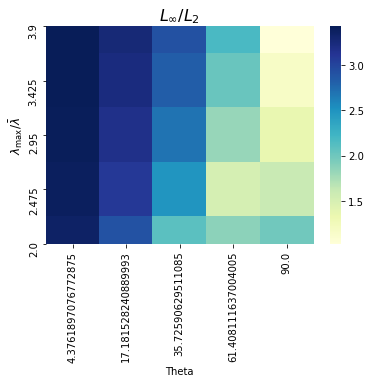

In [34]:


smoothness_sum= np.zeros((len(ratio_tab),len(t_tab)))
aver=5

for i in range(aver): 
    print('New experiment: '+str(i))
    x0=np.random.normal(0, 1, d)

    smoothness_tab,angle_tab  = smoothness(d,x0,eta1,T,ratio_tab,t_tab,dataset)
    
    smoothness_sum+= smoothness_tab
     
    
smoothness_sum/=aver


import seaborn as sns

ax = sns.heatmap(np.flip(np.flip(smoothness_sum,axis=0),axis=1),xticklabels=angle_tab[::-1],yticklabels=ratio_tab[::-1],  cmap="YlGnBu")
plt.xlabel("Theta")
plt.ylabel(r'$\lambda_{\max}/\bar{\lambda}$',fontsize=12)
plt.title(r"$L_{\infty}/L_2$",fontsize=16)
plt.show()

#### Optimization

In [35]:
gd_sum=np.zeros((T,len(ratio_tab),len(t_tab)))
eg_sum=np.zeros((T,len(ratio_tab),len(t_tab)))
gd_sgn_sum=np.zeros((T,len(ratio_tab),len(t_tab)))
eg_sgn_sum=np.zeros((T,len(ratio_tab),len(t_tab)))

eigs_sum= np.zeros((2*d,len(ratio_tab),len(t_tab)))
L2_sum= np.zeros((len(ratio_tab),len(t_tab)))
Linf_sum= np.zeros((len(ratio_tab),len(t_tab)))

In [36]:
aver=5


In [37]:
for i in range(aver): 
    print('New experiment: '+str(i))
    x0=np.random.normal(0, 1, d)
    y0=np.random.normal(0, 1, d)

    gd, eg, gd_sgn,eg_sgn,eigs, L2_tab, Linf_tab, angle_tab = exps(d,x0,y0,eta1,eta2,T,ratio_tab,t_tab,dataset)
    
    gd_sum+=gd
    eg_sum+=eg
    gd_sgn_sum+=gd_sgn  
    eg_sgn_sum+=eg_sgn 
    eigs_sum+=eigs
    L2_sum+=L2_tab
    Linf_sum+=Linf_tab
    
gd_sum/=aver
eg_sum/=aver
gd_sgn_sum/=aver 
eg_sgn_sum/=aver 
eigs_sum/=aver
L2_sum/=aver
Linf_sum/=aver

New experiment: 0
New experiment: 1
New experiment: 2
New experiment: 3
New experiment: 4


In [38]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1  

### Display the plots

Eigenvalues:3.00 1.00 1.00 1.00
L2: 3.00
L_inf: 6.00
L_inf/L_2:2.00


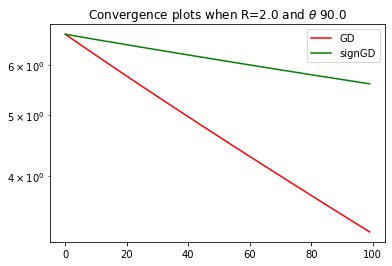

Eigenvalues:3.00 1.00 1.00 1.00
L2: 3.37
L_inf: 6.31
L_inf/L_2:1.87


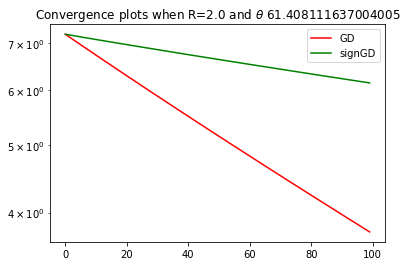

Eigenvalues:3.00 1.00 1.00 1.00
L2: 4.67
L_inf: 9.82
L_inf/L_2:2.10


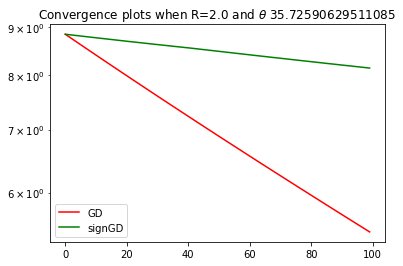

Eigenvalues:3.00 1.00 1.00 1.00
L2: 8.57
L_inf: 24.92
L_inf/L_2:2.91


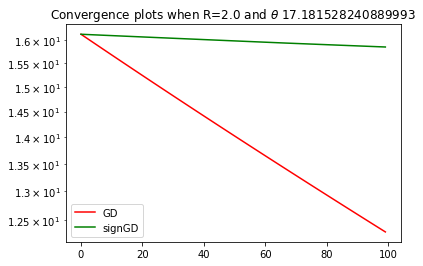

Eigenvalues:3.00 1.00 1.00 1.00
L2: 32.18
L_inf: 108.00
L_inf/L_2:3.36


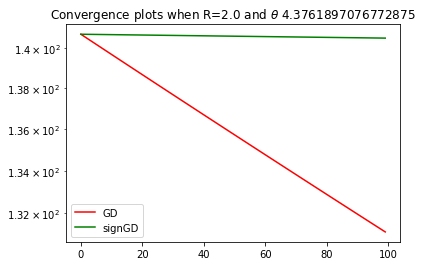

Eigenvalues:4.87 1.00 1.00 1.00
L2: 4.87
L_inf: 7.87
L_inf/L_2:1.62


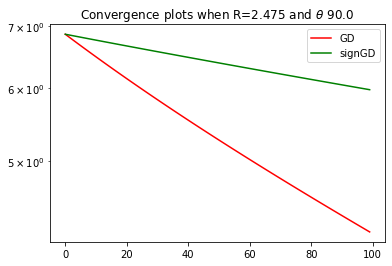

Eigenvalues:4.87 1.00 1.00 1.00
L2: 5.66
L_inf: 8.61
L_inf/L_2:1.52


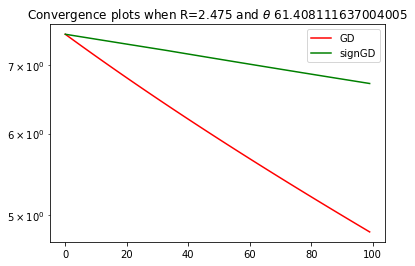

Eigenvalues:4.87 1.00 1.00 1.00
L2: 8.38
L_inf: 20.86
L_inf/L_2:2.49


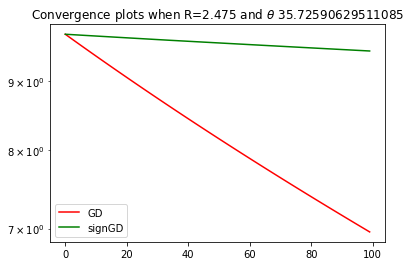

Eigenvalues:4.87 1.00 1.00 1.00
L2: 16.19
L_inf: 50.08
L_inf/L_2:3.09


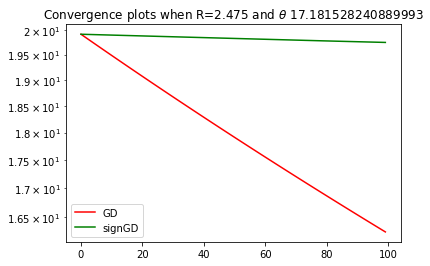

Eigenvalues:4.87 1.00 1.00 1.00
L2: 62.14
L_inf: 210.79
L_inf/L_2:3.39


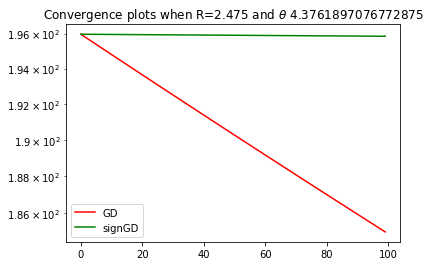

Eigenvalues:8.43 1.00 1.00 1.00
L2: 8.43
L_inf: 11.43
L_inf/L_2:1.36


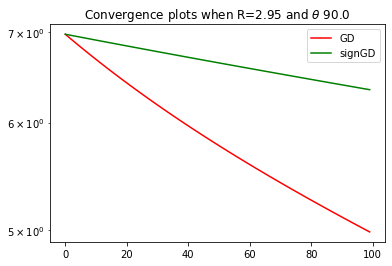

Eigenvalues:8.43 1.00 1.00 1.00
L2: 10.06
L_inf: 18.37
L_inf/L_2:1.83


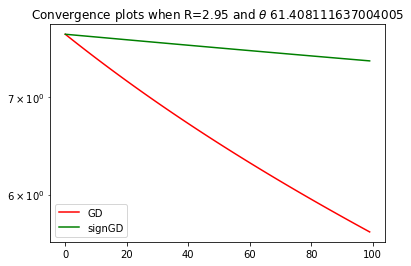

Eigenvalues:8.43 1.00 1.00 1.00
L2: 15.51
L_inf: 41.90
L_inf/L_2:2.70


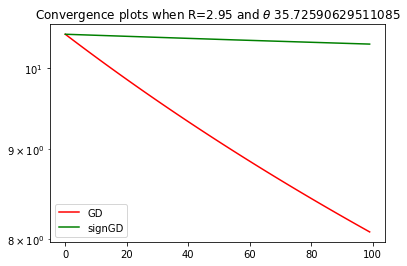

Eigenvalues:8.43 1.00 1.00 1.00
L2: 30.79
L_inf: 98.00
L_inf/L_2:3.18


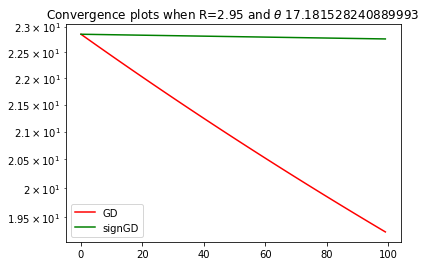

Eigenvalues:8.43 1.00 1.00 1.00
L2: 119.23
L_inf: 406.57
L_inf/L_2:3.41


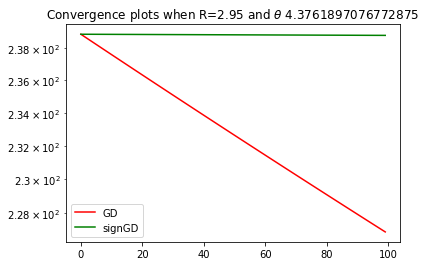

Eigenvalues:17.87 1.00 1.00 1.00
L2: 17.87
L_inf: 20.87
L_inf/L_2:1.17


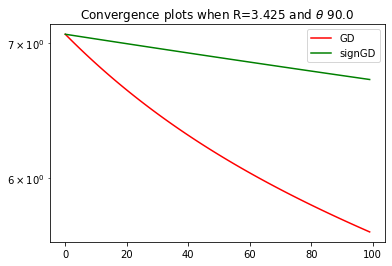

Eigenvalues:17.87 1.00 1.00 1.00
L2: 21.76
L_inf: 44.26
L_inf/L_2:2.03


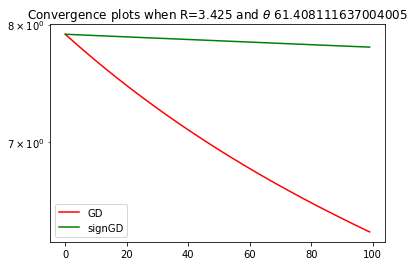

Eigenvalues:17.87 1.00 1.00 1.00
L2: 34.50
L_inf: 97.68
L_inf/L_2:2.83


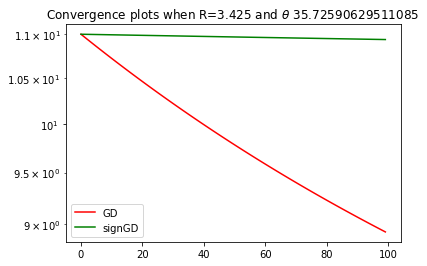

Eigenvalues:17.87 1.00 1.00 1.00
L2: 69.55
L_inf: 225.09
L_inf/L_2:3.24


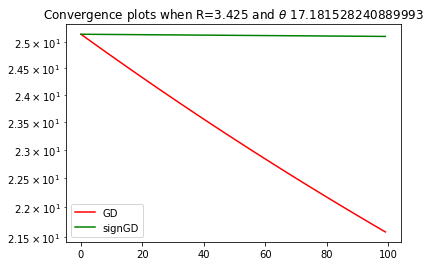

Eigenvalues:17.87 1.00 1.00 1.00
L2: 270.67
L_inf: 925.83
L_inf/L_2:3.42


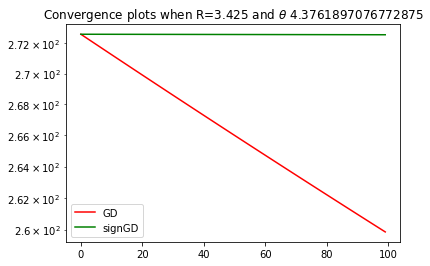

Eigenvalues:117.00 1.00 1.00 1.00
L2: 117.00
L_inf: 120.00
L_inf/L_2:1.03


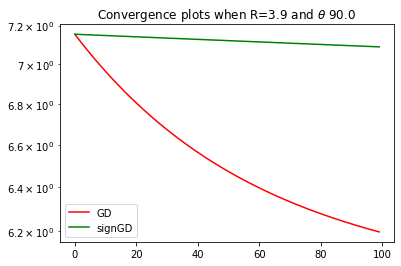

Eigenvalues:117.00 1.00 1.00 1.00
L2: 144.81
L_inf: 316.06
L_inf/L_2:2.18


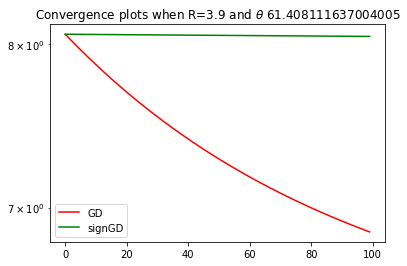

Eigenvalues:117.00 1.00 1.00 1.00
L2: 234.18
L_inf: 683.45
L_inf/L_2:2.92


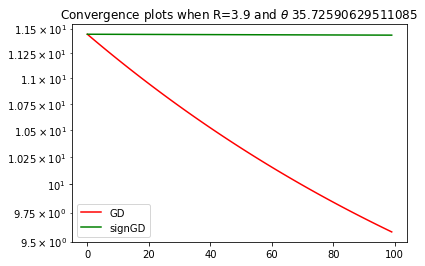

Eigenvalues:117.00 1.00 1.00 1.00
L2: 476.71
L_inf: 1559.54
L_inf/L_2:3.27


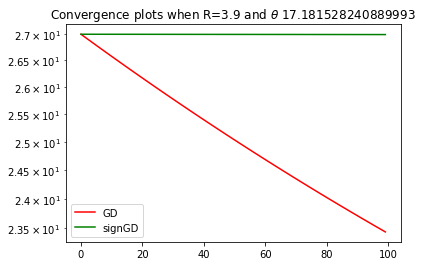

Eigenvalues:117.00 1.00 1.00 1.00
L2: 1860.82
L_inf: 6378.00
L_inf/L_2:3.43


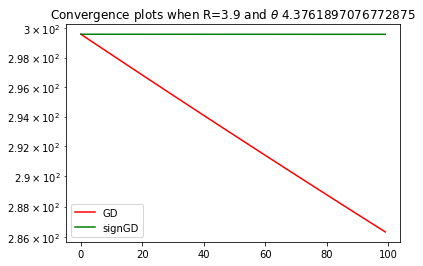

In [39]:
for i in range(len(ratio_tab)): 
    for j in range(len(t_tab)):
        
        listToStr = ' '.join(["%.2f" % elem for elem in eigs_sum[:,i,j]]) 
        
        ratio_smoothness= Linf_sum[i,j]/L2_sum[i,j]
        print('Eigenvalues:'+listToStr )
        print('L2: '+str("%.2f" %L2_sum[i,j]))
        print('L_inf: '+str("%.2f" %Linf_sum[i,j]))
        print('L_inf/L_2:'"%.2f" % ratio_smoothness)

        it_gd = gd_sum[:,i,j]
        it_eg = eg_sum[:,i,j]
        it_sgn = gd_sgn_sum[:,i,j]
        it_egsgn = eg_sgn_sum[:,i,j]
        
        plt.semilogy(range(T), it_gd,'r-',label='GD')
        #plt.semilogy(range(T), it_eg,'b-',label='EG')
        plt.semilogy(range(T), it_sgn,'g-',label='signGD')
        #plt.semilogy(range(T), it_egsgn,'c-',label='sgnEG')
        plt.title('Convergence plots when R='+str(ratio_tab[i])+r' and $\theta$ '+str(angle_tab[j]))
        plt.legend()
        plt.show()
        
        